In [65]:
#import packages
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import xgboost as xgb
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator


# Silence some expected warnings
filterwarnings("ignore")

# # Fix seed for reproducible results
SEED = 22
torch.manual_seed(SEED)

In [51]:
# Read data from previous talktorials
chembl_df = pd.read_csv( "pIC50_prediction/data/EGFR_compounds_lipinski.csv", index_col=0)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (4635, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


In [52]:
# Split dataframe into train and test set
train, test = train_test_split(chembl_df, test_size=0.2, random_state=SEED, shuffle=True)

In [53]:
train

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
3135,CHEMBL485070,400.0,nM,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,6.397940,354.103813,5,2,3.47548,True
4597,CHEMBL4202780,6070.0,nM,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,5.216811,551.241166,9,2,4.48260,True
2137,CHEMBL3676348,65.0,nM,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,7.187087,426.120716,7,3,3.06120,True
3760,CHEMBL425402,1100.0,nM,Fc1ccc(Nc2ncnc3c2NCc2ccccc2O3)cc1Cl,5.958607,342.068367,5,2,4.73050,True
3495,CHEMBL116547,750.0,nM,COc1cc(/C=C(\C#N)C(=O)c2ccc(O)c(O)c2)cc(CSCc2c...,6.124939,447.114044,7,3,5.03528,True
...,...,...,...,...,...,...,...,...,...,...
3143,CHEMBL1830280,410.0,nM,NC(=S)N/N=C(/C=C/c1cccc2ccccc12)c1ccccc1,6.387216,331.114319,2,2,4.09050,True
3647,CHEMBL3133906,931.0,nM,C=CC(=O)Nc1ccc2ncnc(Nc3ccc(OC)cc3OC)c2c1,6.031050,350.137890,6,2,3.51510,True
5519,CHEMBL449114,400000.0,nM,N#CC(C#N)=C(C#N)c1cccc(O)c1,3.397940,195.043262,4,1,1.71654,True
409,CHEMBL4206288,2.1,nM,CN1CCN(c2ccc(Nc3cc4c(N5CCOCC5)nc(Nc5ccccc5)nc4...,8.677781,497.265157,10,2,3.49540,True


## EDA

In [54]:
train.describe()

,IC50,pIC50,molecular_weight,n_hba,n_hbd,logp
count,3.708000e+03,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000
mean,2.434615e+04,6.596884,414.796216,5.985437,1.894822,4.080428
std,4.342665e+05,1.423330,87.402387,1.877070,1.009662,1.194282
min,6.000000e-03,1.602060,110.036779,0.000000,0.000000,-5.994500
25%,2.000000e+01,5.467567,354.126783,5.000000,1.000000,3.429775
50%,2.565000e+02,6.590913,419.172491,6.000000,2.000000,4.165700
75%,3.407500e+03,7.698970,476.159498,7.000000,3.000000,4.813025
max,2.500000e+07,11.221849,704.185617,11.000000,8.000000,8.782600


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3708 entries, 3135 to 3627
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  3708 non-null   object 
 1   IC50                3708 non-null   float64
 2   units               3708 non-null   object 
 3   smiles              3708 non-null   object 
 4   pIC50               3708 non-null   float64
 5   molecular_weight    3708 non-null   float64
 6   n_hba               3708 non-null   int64  
 7   n_hbd               3708 non-null   int64  
 8   logp                3708 non-null   float64
 9   ro5_fulfilled       3708 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 293.3+ KB


In [8]:
# confirm no missing values: 
train.isnull().sum()  

molecule_chembl_id    0
IC50                  0
units                 0
smiles                0
pIC50                 0
molecular_weight      0
n_hba                 0
n_hbd                 0
logp                  0
ro5_fulfilled         0
dtype: int64

In [10]:
#check for duplicated rows
train.duplicated().sum()

0

All rows are unique.

In [55]:
#add label column for pIC50 > 8
train["label"] = np.where(train["pIC50"]>8, 1,0)

In [13]:
train

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,label
3135,CHEMBL485070,400.0,nM,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,6.397940,354.103813,5,2,3.47548,True,0
4597,CHEMBL4202780,6070.0,nM,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,5.216811,551.241166,9,2,4.48260,True,0
2137,CHEMBL3676348,65.0,nM,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,7.187087,426.120716,7,3,3.06120,True,0
3760,CHEMBL425402,1100.0,nM,Fc1ccc(Nc2ncnc3c2NCc2ccccc2O3)cc1Cl,5.958607,342.068367,5,2,4.73050,True,0
3495,CHEMBL116547,750.0,nM,COc1cc(/C=C(\C#N)C(=O)c2ccc(O)c(O)c2)cc(CSCc2c...,6.124939,447.114044,7,3,5.03528,True,0
...,...,...,...,...,...,...,...,...,...,...,...
3143,CHEMBL1830280,410.0,nM,NC(=S)N/N=C(/C=C/c1cccc2ccccc12)c1ccccc1,6.387216,331.114319,2,2,4.09050,True,0
3647,CHEMBL3133906,931.0,nM,C=CC(=O)Nc1ccc2ncnc(Nc3ccc(OC)cc3OC)c2c1,6.031050,350.137890,6,2,3.51510,True,0
5519,CHEMBL449114,400000.0,nM,N#CC(C#N)=C(C#N)c1cccc(O)c1,3.397940,195.043262,4,1,1.71654,True,0
409,CHEMBL4206288,2.1,nM,CN1CCN(c2ccc(Nc3cc4c(N5CCOCC5)nc(Nc5ccccc5)nc4...,8.677781,497.265157,10,2,3.49540,True,1


In [56]:
#remove pIC50 as a feature
train.drop(columns=["pIC50","IC50"], inplace=True)

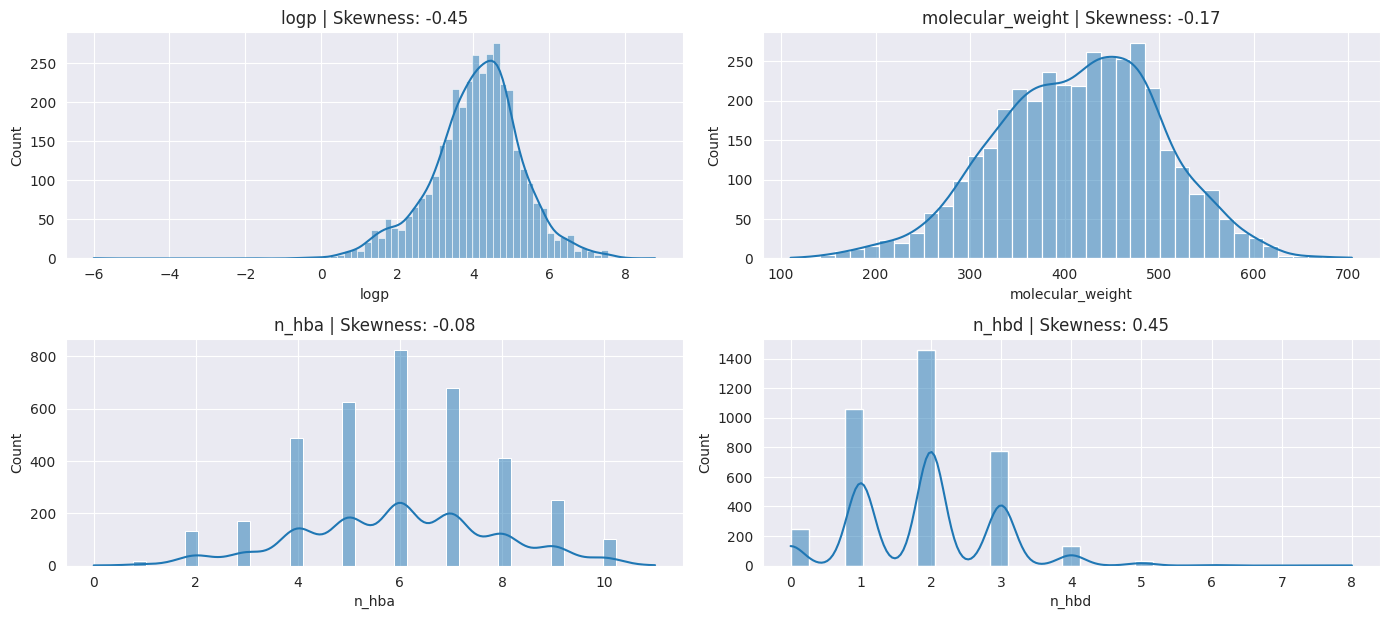

In [38]:
#visualise distribution of numerical features
# Set Seaborn style 
sns.set_style("darkgrid") 
  
# Identify numerical columns 
numerical_columns = train.select_dtypes(include=["int64", "float64"]).columns.difference(['label'])
  
# Plot distribution of each numerical feature 
plt.figure(figsize=(14, len(numerical_columns) * 3)) 
for idx, feature in enumerate(numerical_columns, 1): 
    plt.subplot(len(numerical_columns), 2, idx) 
    sns.histplot(train[feature], kde=True) 
    plt.title(f"{feature} | Skewness: {round(train[feature].skew(), 2)}") 
  
# Adjust layout and show plots 
plt.tight_layout() 
plt.show() 

<Axes: xlabel='label', ylabel='count'>

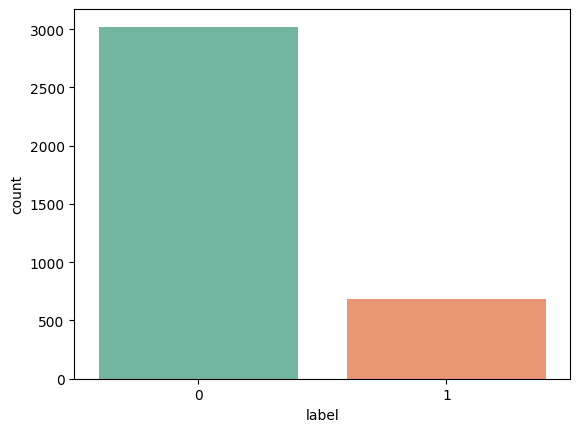

In [24]:
#Plot the unique values of categorical variables
sns.countplot(x ='label', data = train, palette = "Set2")

In [57]:
print(train['label'].value_counts()[0])
print(train['label'].value_counts()[1])

3021
687


label has ~ 5:1 class imbalance.

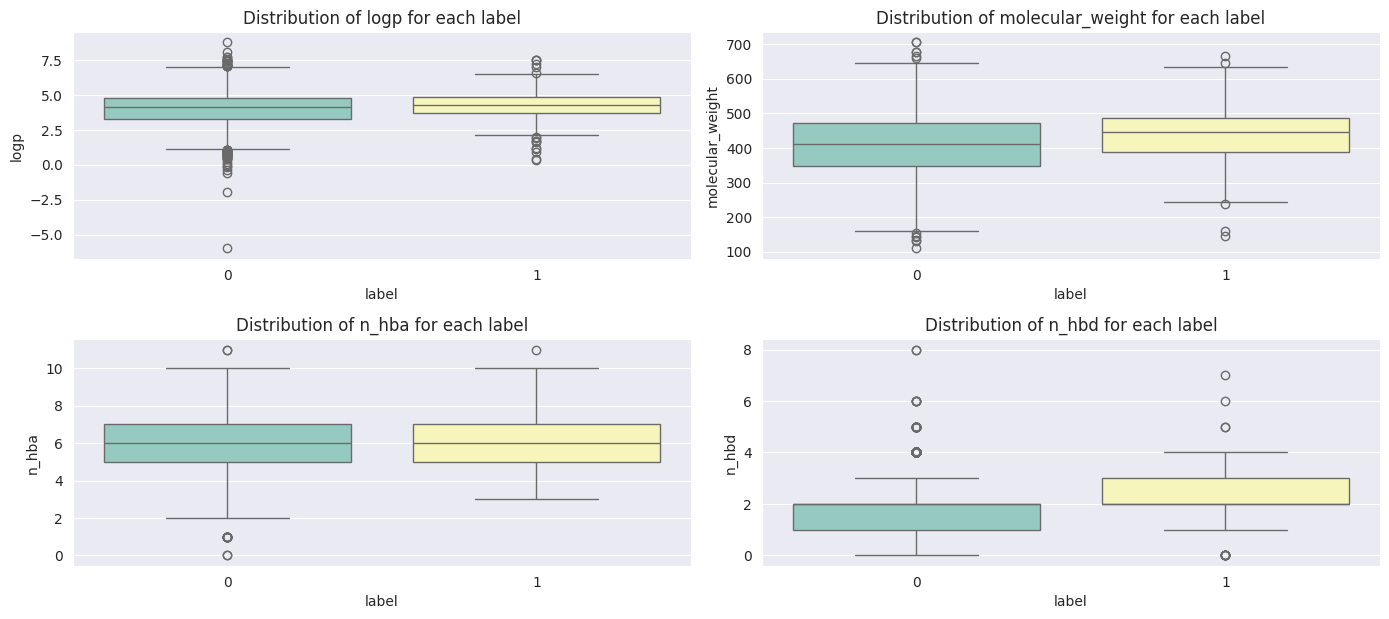

In [39]:
plt.figure(figsize=(14, len(numerical_columns) * 3)) 
for idx, feature in enumerate(numerical_columns, 1): 
    plt.subplot(len(numerical_columns), 2, idx) 
    sns.boxplot(data=train, y=feature, x='label', palette='Set3')
    plt.title(f"Distribution of {feature} for each label") 
  
# Adjust layout and show plots 
plt.tight_layout() 
plt.show() 

In [40]:
#correlation of numerical features
train.select_dtypes(include=["int64", "float64"]).corr()

,molecular_weight,n_hba,n_hbd,logp,label
molecular_weight,1.000000,0.621122,0.235278,0.405698,0.146157
n_hba,0.621122,1.000000,0.214834,-0.152291,0.119833
n_hbd,0.235278,0.214834,1.000000,-0.125048,0.107441
logp,0.405698,-0.152291,-0.125048,1.000000,0.080532
label,0.146157,0.119833,0.107441,0.080532,1.000000


<Axes: >

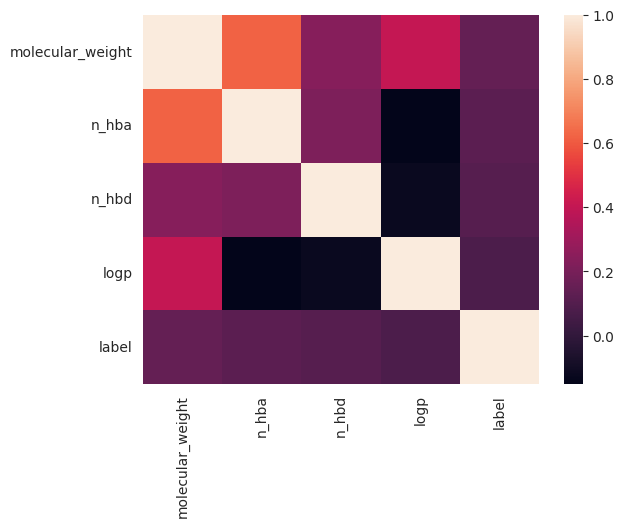

In [41]:
#Correlation plot
sns.heatmap(train.select_dtypes(include=["int64", "float64"]).corr())

Label is not linearly correlated with any of the features 

In [42]:
# Compare categorical variables
CrosstabResult=pd.crosstab(index=train['label'],columns=train['ro5_fulfilled'])
print(CrosstabResult)

ro5_fulfilled  True
label              
0              3021
1               687


In [44]:
print(train['ro5_fulfilled'].value_counts()[True])

3708


ro5_fulfilled is true for both labels so not a very useful feature

## Model

I am using an xgboost model as it's good with non-linear interactions

In [46]:
train.head()

,molecule_chembl_id,units,smiles,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,label
3135,CHEMBL485070,nM,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,354.103813,5,2,3.47548,True,0
4597,CHEMBL4202780,nM,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,551.241166,9,2,4.48260,True,0
2137,CHEMBL3676348,nM,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,426.120716,7,3,3.06120,True,0
3760,CHEMBL425402,nM,Fc1ccc(Nc2ncnc3c2NCc2ccccc2O3)cc1Cl,342.068367,5,2,4.73050,True,0
3495,CHEMBL116547,nM,COc1cc(/C=C(\C#N)C(=O)c2ccc(O)c(O)c2)cc(CSCc2c...,447.114044,7,3,5.03528,True,0


In [58]:
# Keep only the columns we want
train = train[["molecule_chembl_id", "smiles","molecular_weight", "n_hba","n_hbd","logp","label"]]
train.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,molecular_weight,n_hba,n_hbd,logp,label
3135,CHEMBL485070,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,354.103813,5,2,3.47548,0
4597,CHEMBL4202780,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,551.241166,9,2,4.48260,0
2137,CHEMBL3676348,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,426.120716,7,3,3.06120,0
3760,CHEMBL425402,Fc1ccc(Nc2ncnc3c2NCc2ccccc2O3)cc1Cl,342.068367,5,2,4.73050,0
3495,CHEMBL116547,COc1cc(/C=C(\C#N)C(=O)c2ccc(O)c(O)c2)cc(CSCc2c...,447.114044,7,3,5.03528,0


In [59]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [60]:
compound_df = train.copy()

In [61]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,molecular_weight,n_hba,n_hbd,logp,label,fp
3135,CHEMBL485070,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,354.103813,5,2,3.47548,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4597,CHEMBL4202780,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,551.241166,9,2,4.48260,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2137,CHEMBL3676348,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,426.120716,7,3,3.06120,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [62]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"pIC50_prediction/results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [63]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [64]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [12]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 3708
Test data size: 927


In [13]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [14]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.50
Specificity: 0.95
AUC: 0.87


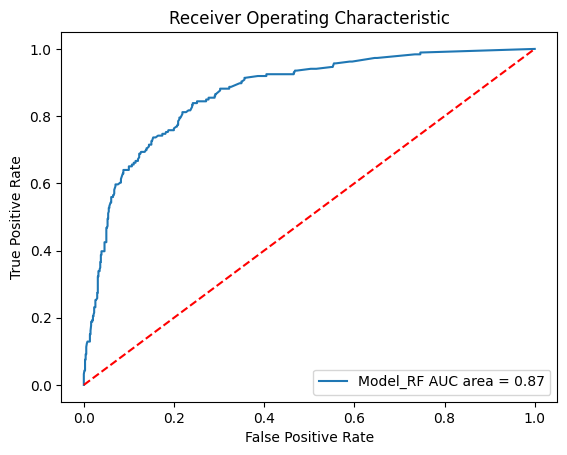

In [15]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [16]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.32
Specificity: 0.98
AUC: 0.86


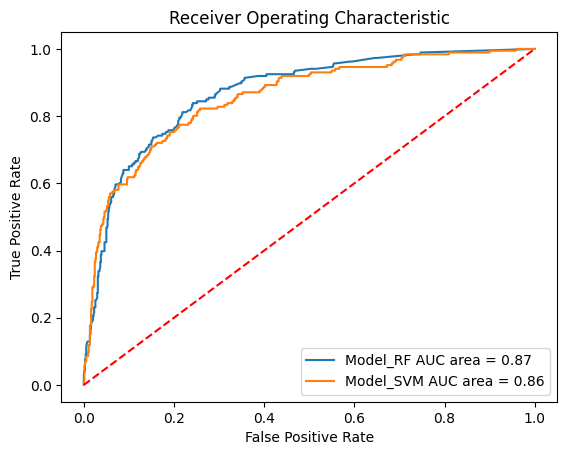

In [17]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [18]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.38
Specificity: 0.94
AUC: 0.84


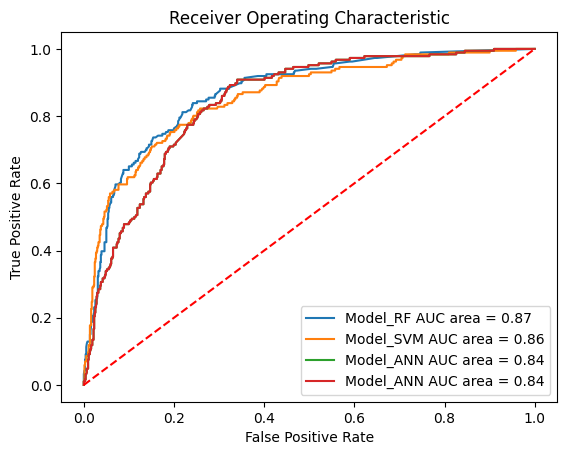

In [22]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

In [23]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [24]:
N_FOLDS = 3

In [25]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.85 	and std : 0.01 
Mean sensitivity: 0.47 	and std : 0.01 
Mean specificity: 0.94 	and std : 0.00 
Mean AUC: 0.87 	and std : 0.00 
Time taken : 1.58s


Model_SVM
Mean accuracy: 0.84 	and std : 0.01 
Mean sensitivity: 0.31 	and std : 0.02 
Mean specificity: 0.97 	and std : 0.00 
Mean AUC: 0.84 	and std : 0.01 
Time taken : 14.57s


Model_ANN
Mean accuracy: 0.82 	and std : 0.01 
Mean sensitivity: 0.35 	and std : 0.04 
Mean specificity: 0.93 	and std : 0.01 
Mean AUC: 0.81 	and std : 0.00 
Time taken : 4.38s


Model_ANN
Mean accuracy: 0.82 	and std : 0.01 
Mean sensitivity: 0.35 	and std : 0.04 
Mean specificity: 0.93 	and std : 0.01 
Mean AUC: 0.81 	and std : 0.00 
Time taken : 4.41s



In [26]:
# Reset data frame
compound_df = chembl_df.copy()

In [27]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.87 	and std : 0.00 
Mean sensitivity: 0.51 	and std : 0.02 
Mean specificity: 0.96 	and std : 0.00 
Mean AUC: 0.90 	and std : 0.00 
Time taken : 4.27s


Model_ANN
Mean accuracy: 0.85 	and std : 0.00 
Mean sensitivity: 0.57 	and std : 0.04 
Mean specificity: 0.91 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 18.14s


Model_ANN
Mean accuracy: 0.85 	and std : 0.00 
Mean sensitivity: 0.57 	and std : 0.04 
Mean specificity: 0.91 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 17.98s

